BIDV

In [1]:
#. Import thư viện cần thiết
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/BIDV.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)


In [3]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/01/2024,53500.0,53300.0,54300.0,52400.0,1250000,0.0094
1,02/29/2024,53000.0,53900.0,54000.0,53000.0,1340000,-0.0167
2,02/28/2024,53900.0,53200.0,54800.0,52300.0,2340000,0.0170
3,02/27/2024,53000.0,53700.0,54000.0,53000.0,1740000,-0.0112
4,02/26/2024,53600.0,52800.0,54500.0,52000.0,1530000,0.0308
...,...,...,...,...,...,...,...
1247,03/07/2019,26710.5,26787.0,26978.3,26557.4,2140000,0.0043
1248,03/06/2019,26595.7,26480.9,26710.5,26327.8,2009999,0.0043
1249,03/05/2019,26480.9,25409.4,27016.6,25409.4,5300000,0.0298
1250,03/04/2019,25715.5,25332.9,25830.3,25256.3,1150000,0.0228


In [4]:
df1=df.reset_index()['Price']

In [5]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [7]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [9]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [10]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0963
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0123
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0059
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0037
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0029
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0022
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0014
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0012
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0011
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0012
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0012
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - lo

In [12]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [13]:
# . Chuẩn hóa dữ liệu y_pred

y_pred=scaler.inverse_transform(y_pred)

In [14]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [15]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 487.3296328953293
Testing MAPE: 1.451090309863935
Testing Mae: 385.7039717911073


In [16]:
#. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

next_30_days = scaler.inverse_transform(lst_output_30)    

In [17]:
#. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

next_60_days = scaler.inverse_transform(lst_output_60)        

In [18]:
# 12. Dự báo 90 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

next_90_days = scaler.inverse_transform(lst_output_90)        

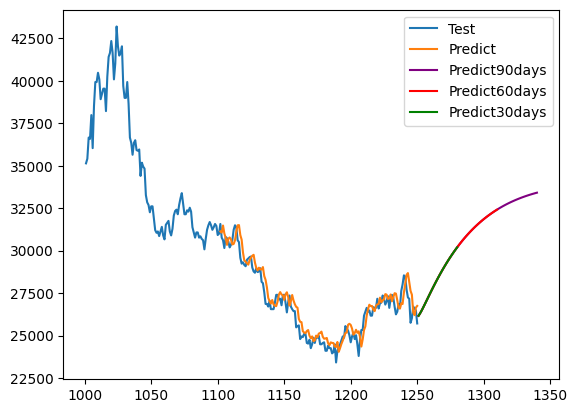

In [19]:
# Vẽ hình dự báo 30 ngày tiếp theo

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,next_90_days, color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,next_60_days, color='red')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,next_30_days, color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()

VIB


In [20]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/VIB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [21]:
df1=df.reset_index()['Price']

In [22]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [23]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [24]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [25]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [26]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


In [27]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2233
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0170
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0102
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0078
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0043
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0023
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0013
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.3824e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.5879e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.9173e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.5228e-04
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7.5468e-04
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.3977e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.5412e-04
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0

In [29]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [30]:
# . Chuẩn hóa dữ liệu y_pred
y_pred=scaler.inverse_transform(y_pred)

In [31]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [32]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 374.8406933302155
Testing MAPE: 1.67124515361784
Testing Mae: 176.49403175147805


In [33]:
#. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

next_30_days = scaler.inverse_transform(lst_output_30)    

In [34]:
#. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

next_60_days = scaler.inverse_transform(lst_output_60)        

In [35]:
# 12. Dự báo 90 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

next_90_days = scaler.inverse_transform(lst_output_90)        

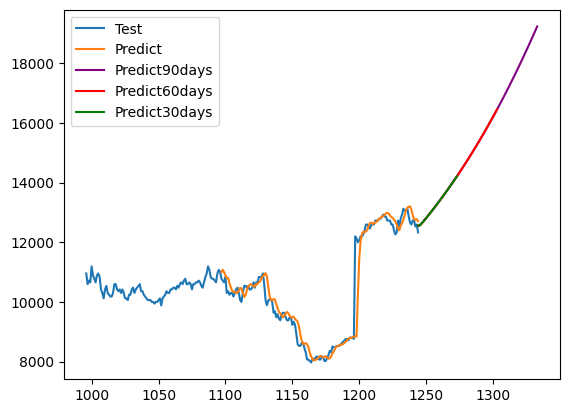

In [36]:
# Vẽ hình dự báo 

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,next_90_days, color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,next_60_days, color='red')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,next_30_days, color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()

STB


In [37]:
# Đọc file và tiền xử lí dữ liệu
df = pd.read_csv('../data/STB.csv')
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [38]:
df1=df.reset_index()['Price']

In [39]:
#. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [40]:
#. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.2 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [41]:
#. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [42]:
#. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [43]:
# . Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [44]:
# . Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
# . Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1374
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0191
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0067
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0032
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0021
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0012
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0010
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.5642e-04
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.5080e-04
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.5320e-04
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.5104e-04
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.1189e-04
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.3060e-04
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.1583e-04
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
# . Dự báo dữ liệu test

y_pred=model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
# . Chuẩn hóa dữ liệu y_pred

y_pred=scaler.inverse_transform(y_pred)

In [ ]:
# Chuẩn hóa dữu liệuu y_test
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Tính RMSE
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Testing RMSE:', test_rmse)

# Tính MAPE (Mean Absolute Percentage Error)
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

#Tinh Mae
mae = np.mean(np.abs(np.array(y_pred) - np.array(y_test)))
print('Testing Mae:', mae)

Testing RMSE: 499.32342111707504
Testing MAPE: 4.1381054340198915
Testing Mae: 440.50313038455516


In [ ]:
#. Dự báo 30 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_30 = []
n_steps = 100
i = 0

while i < 30:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_30.extend(yhat.tolist())
        i = i + 1

next_30_days = scaler.inverse_transform(lst_output_30)    

In [ ]:
#. Dự báo 60 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_60 = []
n_steps = 100
i = 0

while i < 60:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_60.extend(yhat.tolist())
        i = i + 1

next_60_days = scaler.inverse_transform(lst_output_60)        

In [ ]:
# 12. Dự báo 90 ngày tiếp theo
x_input = test_data[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output_90 = []
n_steps = 100
i = 0

while i < 90:
    if len(temp_input) > 100:
        # print(temp_input)
        x_input = np.array(temp_input[-100:])  # Ensure x_input has exactly 100 elements
        # print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        # print(temp_input)
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use the available elements
        x_input = x_input.reshape((1, len(temp_input), 1))  # Reshape according to the actual length
        yhat = model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output_90.extend(yhat.tolist())
        i = i + 1

next_90_days = scaler.inverse_transform(lst_output_90)        

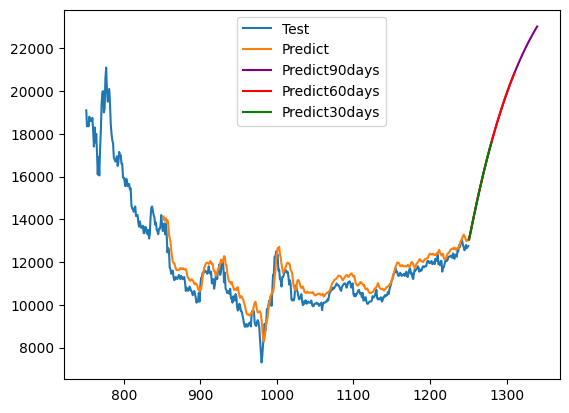

In [ ]:
#Vẽ hình dự báo 

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred))

predict_data_index_90 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(predict_data_index_90,next_90_days, color='purple')
predict_data_index_60 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(predict_data_index_60,next_60_days, color='red')
predict_data_index_30 = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index_30,next_30_days, color='green')
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])

plt.show()